### import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torchmetrics import Accuracy, ConfusionMatrix, Precision, Recall, F1Score

from tqdm import tqdm

### Load datasets

In [2]:

t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
    ]
)

dataset = datasets.ImageFolder(root="/media/mowli/New Volume/Guvi/capston/FN/eye_diseases_prediction/eye/dataset", transform=t)


In [3]:
# number of classes
NUMBER_OF_CLASSES = len(set(dataset.targets))

In [4]:
print(f"Number of classes: {NUMBER_OF_CLASSES}")


Number of classes: 4


Label : cataract


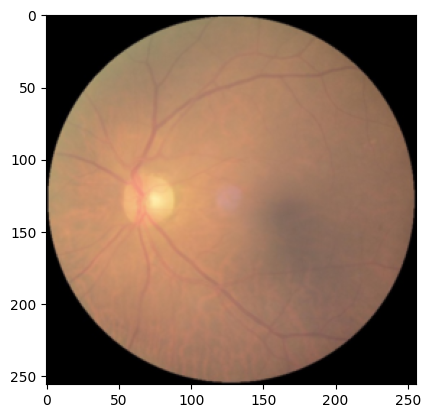

In [5]:
def display_image(image, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(image.permute(1, 2, 0))


# display the first image in the dataset
display_image(*dataset[5])

### Train model

In [6]:
def train_test_split(dataset, train_size, random_state=42):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    seed = torch.Generator().manual_seed(random_state)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=seed
    )

    return train_dataset, test_dataset

In [7]:
train_dataset, test_dataset = train_test_split(dataset, 0.8)


In [8]:
batch_size = 32
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


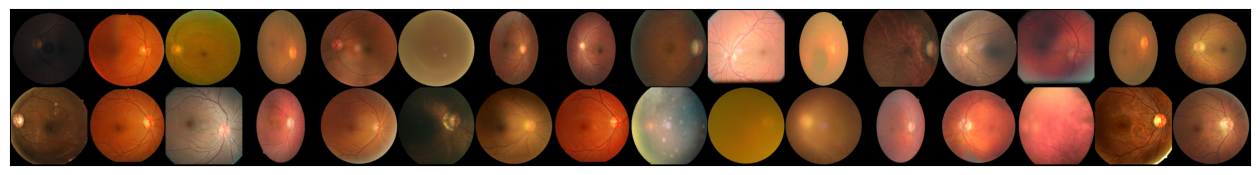

In [9]:
def show_batch(data_loader):
    """Plot images grid of single batch"""
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


show_batch(train_dataloader)

### Build CNN Architech

In [10]:
class CNN(nn.Module):
    def __init__(self, NUMBER_OF_CLASSES):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, NUMBER_OF_CLASSES),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)

        return x

In [11]:
model = CNN(NUMBER_OF_CLASSES)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"
device

'cpu'

In [14]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    model.to(device)
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    accuracy = Accuracy(task="multiclass",
                        num_classes=NUMBER_OF_CLASSES).to(device)
    for epoch in range(epochs):
        train_loss = []
        for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{epochs}'):
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss
        train_loss = np.mean(train_loss)
        # Train accuracy
        train_accuracy = accuracy(outputs, targets)

        test_loss = []
        for inputs, targets in tqdm(test_loader, desc=f'Validating... Epoch: {epoch + 1}/{epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())

        # Get test loss
        test_loss = np.mean(test_loss)
        # Test accuracy
        test_accuracy = accuracy(outputs, targets)

        # Save losses
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss

        print(f"Epoch {epoch+1}/{epochs}:")
        print(
            f"Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}")
        print(
            f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")
        print('-'*30)

    return train_losses, test_losses


In [15]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_dataloader, test_dataloader, epochs=10
)

Validating... Epoch: 1/10: 100%|██████████| 27/27 [00:06<00:00,  4.04it/s]


Epoch 1/10:
Train Loss: 0.88, Train Accuracy: 0.69
Test Loss: 0.71, Test Accuracy: 0.58
------------------------------


Validating... Epoch: 2/10: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Epoch 2/10:
Train Loss: 0.60, Train Accuracy: 0.85
Test Loss: 0.54, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 3/10: 100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Epoch 3/10:
Train Loss: 0.53, Train Accuracy: 0.85
Test Loss: 0.49, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 4/10: 100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Epoch 4/10:
Train Loss: 0.49, Train Accuracy: 0.77
Test Loss: 0.53, Test Accuracy: 0.92
------------------------------


Validating... Epoch: 5/10: 100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Epoch 5/10:
Train Loss: 0.47, Train Accuracy: 0.85
Test Loss: 0.45, Test Accuracy: 0.83
------------------------------


Validating... Epoch: 6/10: 100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Epoch 6/10:
Train Loss: 0.42, Train Accuracy: 0.77
Test Loss: 0.46, Test Accuracy: 0.75
------------------------------


Validating... Epoch: 7/10: 100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


Epoch 7/10:
Train Loss: 0.41, Train Accuracy: 0.92
Test Loss: 0.43, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 8/10: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Epoch 8/10:
Train Loss: 0.38, Train Accuracy: 0.85
Test Loss: 0.44, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 9/10: 100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Epoch 9/10:
Train Loss: 0.39, Train Accuracy: 1.00
Test Loss: 0.42, Test Accuracy: 1.00
------------------------------


Validating... Epoch: 10/10: 100%|██████████| 27/27 [00:07<00:00,  3.80it/s]

Epoch 10/10:
Train Loss: 0.36, Train Accuracy: 0.92
Test Loss: 0.38, Test Accuracy: 0.92
------------------------------


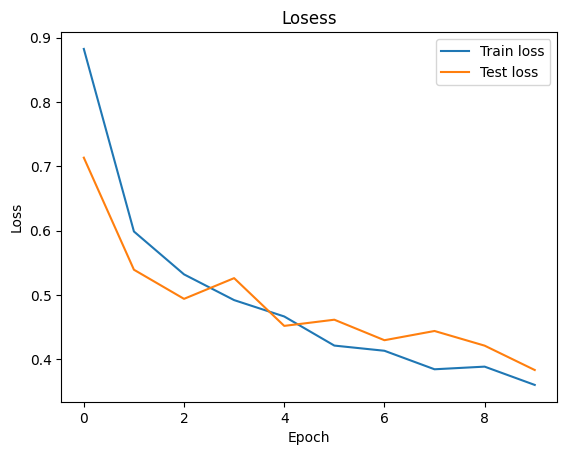

In [16]:
plt.title("Losess")
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### prediction

In [17]:
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predections = torch.max(outputs, 1)

        y_pred_list.append(targets.cpu().numpy())
        y_true_list.append(predections.cpu().numpy())

targets = torch.tensor(np.concatenate(y_true_list))
preds = torch.tensor(np.concatenate(y_pred_list))

In [18]:
preds

tensor([3, 1, 0, 0, 3, 2, 3, 3, 0, 0, 2, 0, 1, 3, 3, 3, 1, 1, 0, 2, 1, 0, 3, 2,
        0, 0, 2, 2, 0, 3, 0, 1, 3, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 3, 1,
        2, 3, 2, 1, 0, 1, 3, 0, 0, 1, 2, 1, 1, 3, 0, 3, 1, 0, 1, 3, 0, 2, 3, 3,
        0, 3, 2, 1, 1, 1, 2, 2, 1, 0, 3, 0, 0, 2, 1, 0, 1, 3, 2, 0, 3, 0, 3, 1,
        1, 0, 2, 3, 2, 1, 3, 2, 0, 0, 2, 3, 0, 2, 0, 3, 1, 0, 3, 2, 2, 0, 0, 0,
        3, 3, 2, 0, 2, 0, 0, 1, 3, 3, 2, 2, 0, 1, 3, 2, 1, 1, 1, 2, 3, 0, 0, 1,
        0, 1, 2, 0, 1, 2, 3, 0, 2, 2, 3, 3, 1, 3, 3, 2, 3, 0, 3, 2, 3, 2, 2, 3,
        3, 2, 0, 1, 3, 2, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 3, 0, 0, 1, 3, 1, 2, 0,
        3, 3, 3, 3, 3, 2, 3, 0, 1, 2, 1, 1, 1, 1, 0, 3, 1, 3, 3, 0, 0, 1, 0, 2,
        3, 0, 1, 1, 2, 2, 3, 2, 2, 3, 0, 2, 3, 0, 2, 2, 1, 3, 0, 1, 2, 3, 1, 2,
        1, 0, 3, 1, 3, 2, 3, 2, 0, 0, 1, 3, 0, 1, 3, 0, 3, 2, 1, 2, 1, 0, 1, 2,
        2, 0, 3, 3, 3, 1, 1, 2, 1, 2, 0, 2, 3, 1, 0, 1, 2, 0, 2, 3, 3, 1, 3, 2,
        0, 0, 0, 2, 1, 2, 2, 0, 2, 3, 1,

In [19]:
targets

tensor([3, 1, 0, 2, 3, 2, 3, 2, 0, 0, 0, 0, 1, 3, 2, 3, 1, 1, 0, 2, 1, 0, 3, 1,
        0, 2, 2, 2, 2, 3, 0, 1, 3, 1, 3, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 1, 0, 1,
        3, 3, 2, 1, 0, 1, 3, 0, 0, 1, 2, 1, 1, 3, 0, 3, 1, 0, 1, 3, 0, 2, 3, 3,
        0, 0, 3, 1, 1, 1, 0, 3, 3, 0, 3, 0, 0, 2, 1, 0, 1, 1, 2, 0, 3, 0, 0, 1,
        1, 0, 2, 3, 0, 1, 3, 3, 0, 0, 3, 3, 0, 2, 0, 3, 1, 0, 3, 2, 2, 0, 0, 0,
        3, 2, 2, 0, 2, 2, 0, 1, 3, 3, 3, 2, 0, 1, 3, 0, 1, 1, 1, 2, 3, 0, 0, 1,
        0, 1, 3, 3, 1, 2, 3, 0, 3, 2, 3, 3, 1, 3, 3, 3, 3, 0, 3, 2, 2, 2, 0, 3,
        3, 2, 0, 1, 3, 2, 0, 3, 1, 1, 1, 3, 1, 1, 2, 0, 3, 0, 0, 1, 2, 1, 2, 0,
        3, 3, 3, 3, 3, 2, 3, 0, 1, 0, 1, 1, 1, 1, 0, 3, 1, 3, 3, 0, 0, 1, 0, 2,
        3, 2, 1, 1, 3, 2, 3, 0, 3, 3, 0, 3, 3, 0, 3, 2, 1, 2, 0, 1, 2, 3, 1, 3,
        1, 0, 3, 1, 3, 0, 3, 2, 0, 0, 1, 3, 1, 1, 3, 2, 3, 3, 1, 3, 1, 0, 1, 2,
        1, 0, 3, 2, 3, 1, 1, 2, 1, 3, 0, 2, 2, 1, 0, 1, 3, 0, 2, 3, 3, 1, 3, 3,
        0, 0, 0, 2, 1, 2, 3, 0, 3, 3, 1,

In [20]:
confmat = ConfusionMatrix(task="multiclass", num_classes=NUMBER_OF_CLASSES)
cm = confmat(preds, targets)

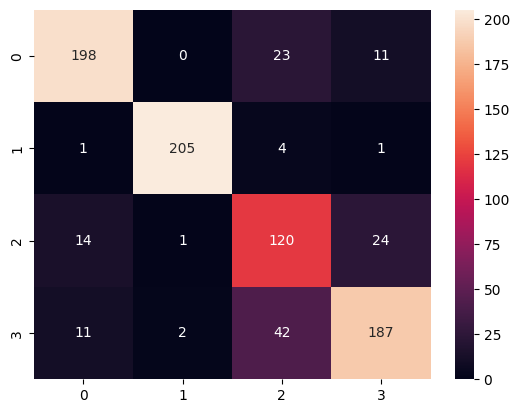

In [21]:
sn.heatmap(cm, annot=True, fmt=".0f")
plt.show()

### Accuracy

In [22]:
accuracy = Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(device)
accuracy = accuracy(preds, targets)
print(f"Accuracy: {100 * accuracy:.2f}%")

Accuracy: 84.12%


In [23]:
precision = Precision(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
precision = precision(preds, targets)
print(f"Precision: {100 * precision:.2f}%")

Precision: 84.12%


In [24]:
recall = Recall(task="multiclass", average='micro', num_classes=NUMBER_OF_CLASSES)
recall = recall(preds, targets)
print(f"Recall: {100 * recall:.2f}%")

Recall: 84.12%


In [25]:
f1 = F1Score(task="multiclass", num_classes=NUMBER_OF_CLASSES)
f1 = f1(preds, targets)
print(f"F1 Score: {100 * f1:.2f}%")

F1 Score: 84.12%
